## SI

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data PE

In [3]:
df = pd.read_csv("new_data/kitabisa_review _SI.csv")
df.head()

content     SI  value
0  Aplikasi kitabisa bagus. Tpi yang diutamakan d...   True      1
1  Kalau memungkinkan  sebaiknya donasi gak terla...  False      0
2  Alhamdulillah sangat sangat membantu. Seneng b...  False      0
3  Assalamualaikum Sebelum terimakasih udah ada a...  False      0
4  Mau berdonasi dr kampanye d ig  tapi pas buka ...   True      1

In [ ]:
df.value.value_counts()

In [ ]:
df.value.value_counts(normalize=True)

### Encoding with W2V Model

In [4]:
from gensim.models import Word2Vec

In [5]:
w2v = Word2Vec.load("model/w2v/kitabisa_review.w2v").wv

In [6]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [7]:
vecs.shape

(7688, 200)

### Dataset Splitting

In [8]:
X = vecs
y = df.value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6150, 200), (1538, 200), (6150,), (1538,))

### SMOTE Data Modeling

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
print(Counter(y))

In [ ]:
sns.countplot(x=y_train)

In [ ]:
for i, color in enumerate(['1', '0']):
    plt.scatter(X[:, 0], X[:, 1], c=['b' if p == i else 'r' for p in y], alpha=0.3, label=color)
plt.legend()
plt.xlabel('X column 0')
plt.ylabel('X column 1')

In [15]:
sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_test, y_res_test = sm.fit_resample(X_test, y_test)



print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Original dataset shape is  Counter({0: 6106, 1: 44})
Resample dataset shape is  Counter({0: 6106, 1: 6106})
Resample dataset test shape is  Counter({0: 1527, 1: 1527})


In [ ]:
print(Counter(y_res))

### Training SVM

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [16]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits
{'algo__C': 1.0, 'algo__gamma': 10.0}
1.0 0.9999180999181 0.5


### Evaluation

In [17]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

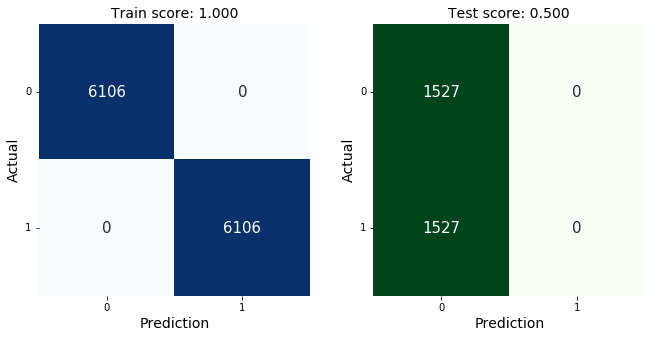

In [18]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [19]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6106
           1       1.00      1.00      1.00      6106

    accuracy                           1.00     12212
   macro avg       1.00      1.00      1.00     12212
weighted avg       1.00      1.00      1.00     12212


Test report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1527
           1       0.00      0.00      0.00      1527

    accuracy                           0.50      3054
   macro avg       0.25      0.50      0.33      3054
weighted avg       0.25      0.50      0.33      3054



C:\Users\Iwan\miniconda3\envs\jcopml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Iwan\miniconda3\envs\jcopml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Iwan\miniconda3\envs\jcopml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Improve menggunakan class weight

In [ ]:
[
    {"False":0.05, "True":0.95},
    {"False":0.1, "True":0.9},
    {"False":0.25, "True":0.75}
]

In [ ]:
gsp.svm_params

In [ ]:
pipeline = Pipeline([
    ('algo', SVC())
])

parameter = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7),
    'algo__class_weight': [{0:x, 1:1-x} for x in [0.01, 0.05, 0.1]]
}

model = GridSearchCV(pipeline, parameter, cv=10, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_test, y_test))

### Evaluation

In [ ]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

### Encoding with FastText

In [5]:
from gensim.models import FastText

In [6]:
fastText = FastText.load("model/fasttext/kitabisa_review.fasttext").wv

In [7]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, fastText, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [ ]:
vecs.shape

### Dataset Splitting

In [8]:
X = vecs
y = df.value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6150, 200), (1538, 200), (6150,), (1538,))

### SMOTE Data Modeling

In [9]:
sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_test, y_res_test = sm.fit_resample(X_test, y_test)



print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Original dataset shape is  Counter({0: 6106, 1: 44})
Resample dataset shape is  Counter({0: 6106, 1: 6106})
Resample dataset test shape is  Counter({0: 1527, 1: 1527})


### Training with SVM

In [13]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits
{'algo__C': 1.0, 'algo__gamma': 10.0}
1.0 0.9999180999181 0.5350360183366077


### Evaluation

In [14]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

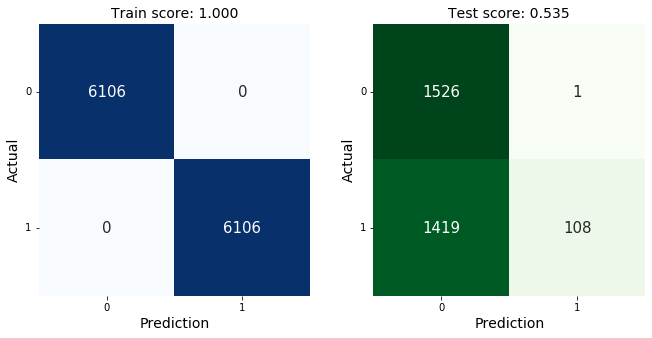

In [15]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [16]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6106
           1       1.00      1.00      1.00      6106

    accuracy                           1.00     12212
   macro avg       1.00      1.00      1.00     12212
weighted avg       1.00      1.00      1.00     12212


Test report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      1527
           1       0.99      0.07      0.13      1527

    accuracy                           0.54      3054
   macro avg       0.75      0.54      0.41      3054
weighted avg       0.75      0.54      0.41      3054



### Improve menggunakan class weight

In [ ]:
pipeline = Pipeline([
    ('algo', SVC())
])

parameter = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7),
    'algo__class_weight': [{0:x, 1:1-x} for x in [0.01, 0.05, 0.1]]
}

model = GridSearchCV(pipeline, parameter, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

In [ ]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)